# Introduction to Reinforcement Learning
## Deep Q Network With CNN

### First, some primary references:

* This notebook closely follows TF-Agents [tutorial on simple DQN Network ](https://colab.research.google.com/github/tensorflow/agents/blob/master/docs/tutorials/1_dqn_tutorial.ipynb#scrollTo=cKOCZlhUgXVK)  The site's requested citation appears at the bottom of this notebook **Assume that the modeling code is mostly cut and pasted from the tutorial**

The notebook also includes code based on PyGame tutorials:
* https://opensource.com/article/17/12/game-python-add-a-player (parts 3-5)
* Similar to above, assume that the code has been taken from the tutorials.  Images are different and rewards are changed, but the tutorial was the baseline and modifications were made on top.

### Description


This notebook uses a simple PyGame with the Deep Q Network

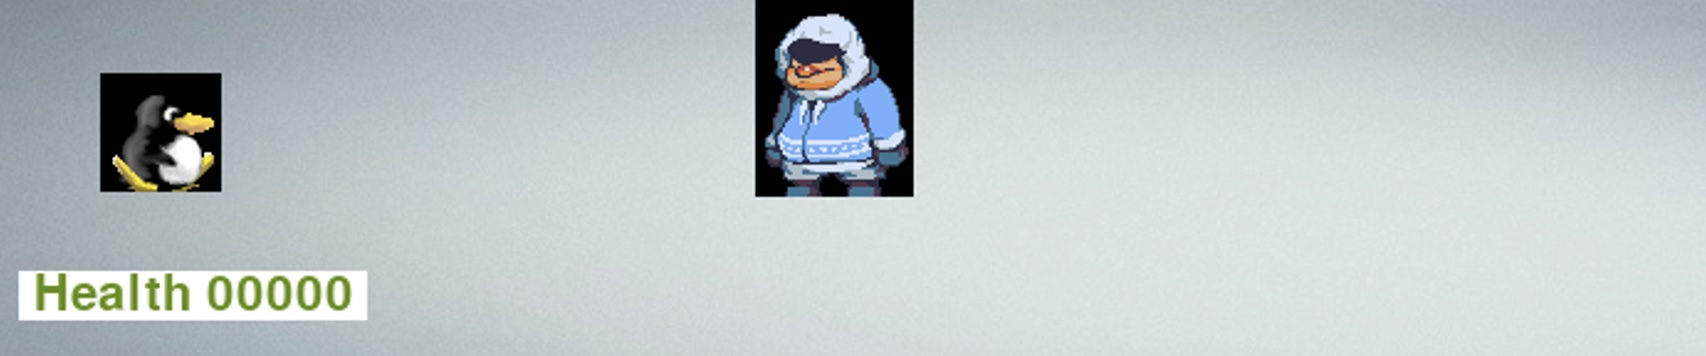



How the game works:
* 1 player/agent (penguin)
* 1 "enemy" (person)
* movement goes along an X axis
* The player is rewarded for each movement (left or right)
* If the player collides with the enemy, it gets a penalty
* If the player is near the enemy (without colliding) it gets higher rewards
* If the player is just moving, it gets a reward

Because Deep Q Networks use a lot of memory, a simple CNN has been used to read the game rendered images.  The training also has less steps than what was done for the 130-pygame-discrete-dqn notebook.  All the notebooks take discrete input; however the CNN is using numpy float image arrays.

Note that while the game versions may differ slightly across the project notebooks, they are conceptually the same.  The TensorFlow environment version is different in the observations it outputs, which align to Tensors of the TensorFlow API


## PIP installs

Below this is conditional to reduce unnecessary imports.  To run
set 
```
run_pip=True
```

In [1]:
run_pip = False

if run_pip:
  !pip install tf-agents
  !pip install opencv-python 
  !pip install pillow
  !pip install pygame
  !sudo apt-get update
  !sudo apt-get install -y xvfb ffmpeg
  !pip install 'imageio==2.4.0'
  !pip install pyvirtualdisplay

## Imports

In [2]:
from IPython import display
import IPython
import base64
import imageio
import numpy as np 
import cv2
from google.colab.patches import cv2_imshow
from IPython import display
#import pandas as pd
#from cStringIO import StringIO
from io import StringIO
import pygame

import matplotlib.pyplot as plt
import PIL.Image as Image
import gym
import random
import os
from google.colab import output
from gym import Env, spaces
from gym.spaces import Discrete, Box
import time
import PIL.Image

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
from tensorflow import TensorShape, TensorSpec

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts
from tf_agents.specs import BoundedArraySpec

from tf_agents.agents.dqn import dqn_agent
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

from tf_agents.networks import q_network


tf.compat.v1.enable_v2_behavior()
font = cv2.FONT_HERSHEY_COMPLEX_SMALL 

pygame 2.0.1 (SDL 2.0.14, Python 3.7.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Google Drive For Files
### This is used for images and saving models



In [3]:
image_dir = 'images'
working_dir = 'MyDrive'
drive_dir = '/content/drive'
model_dir = 'models'
output_dir = 'output'

In [4]:
from google.colab import drive
drive.mount(drive_dir)  # Do this once only

mounted_drive = f'{drive_dir}/{working_dir}'
os.chdir(mounted_drive)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## PyGame Sprites

As was stated earlier.  Most of this code very closely follows or was taken from tutorials.

The PyGame was adapted:
* Open source images were used for the character sprites 
* The reward system came from trying to train the player sprite to take risks to go up to the enemy however hopefully not die
* The rendering of the game images was modified to be viewed with PIL and at one point even plotted with matplotlib
* Text rendering was based on other articles to provide a score
* Actions were changed from key presses to numbers 
* Movement was restricted to the X-axis

In [5]:
ALPHA = (0, 255, 0)
ani = 4
class Player(pygame.sprite.Sprite):
    """
    Spawn a player
    """

    def __init__(self):
        pygame.sprite.Sprite.__init__(self)
        self.movex = np.random.choice(np.arange(40,900)) # for now let's try 150 originally this was 0
        self.movey = 0
        self.frame = 0
        self.health = 0
        self.images = []
        self.limits = [60,900]
        self.penalty = -100
        self.incentive_reward = 25
        
        
        for i in range(1, 5):
            #img = pygame.image.load(os.path.join('images', 'hero' + str(i) + '.png')).convert()
            img = pygame.image.load(f'{image_dir}/hero{str(i)}.png').convert()
            img.convert_alpha()
            img.set_colorkey(ALPHA)
            self.images.append(img)
            self.image = self.images[0]
            self.rect = self.image.get_rect()

    def control(self, x, y):
        """
        control player movement
        """
        
        self.movex = x * 10
        self.movey += y

    def update(self):
        """
        Update sprite position
        """

        self.rect.x = self.rect.x + self.movex
        self.rect.y = self.rect.y + self.movey

        # moving left
        if self.movex < 0:
            self.frame += 1
            if self.frame > 3*ani:
                self.frame = 0
            self.image = pygame.transform.flip(self.images[self.frame // ani], True, False)

        # moving right
        if self.movex > 0:
            self.frame += 1
            if self.frame > 3*ani:
                self.frame = 0
            self.image = self.images[self.frame//ani]
        
        self.hit_list = pygame.sprite.spritecollide(self, self.enemy_list, False)
        
        reward = 0
        if not self.check_collisions():
            for e in self.enemy_list:
              distance = abs(self.rect.x - e.rect.x)
              
              if distance < 150 and distance > 100:
                  reward = self.incentive_reward
                  
        else:
          reward = self.penalty
        return reward
        

      
    def check_collisions(self):
        """
        Check collisions sprite position
        """
        is_hit = False
        for enemy in self.hit_list:
            is_hit = True
            
        return is_hit

class Enemy(pygame.sprite.Sprite):
    """
    Spawn an enemy
    """
    def __init__(self, x, y, img):
        pygame.sprite.Sprite.__init__(self)
        
        self.limits=[0,930]
        self.image = pygame.image.load(img)
        self.image.convert_alpha()
        self.image.set_colorkey(ALPHA)
        self.rect = self.image.get_rect()
        self.rect.x = x
        self.rect.y = y
        self.counter = 0
        self.active = True

    def move(self):
        """
        enemy movement
        """
        distance = 80
        speed = 8
        if not self.active:
          return

        if self.counter >= 0 and self.counter <= distance:
            self.rect.x += speed
        elif self.counter >= distance and self.counter <= distance*2:
            self.rect.x -= speed
        else:
            self.counter = 0

        self.counter += 1
    
    def deactivate(self):
        self.active = False

    def activate(self):
        self.active = True

class Level():
    def bad(lvl, eloc):
        if lvl == 1:
            enemy = Enemy(eloc[0], eloc[1], f'{image_dir}/enemy.png')
            enemy_list = pygame.sprite.Group()
            enemy_list.add(enemy)
        if lvl == 2:
            print("Level " + str(lvl) )

        return enemy_list

## Setting Up Reinforcement Learning Environment

To work with TensorFlow Agents, the environment class needs to be in a TF_Environment

1. We'll create a PyEnvironment class with the following environment
2. This will be wrapped in a TFEnvironment class that can be passed into the agent

Below are the methods that will be added to the game to make the class a PyEnvironment


### Environment Methods

```
  def reset(self):

  # """Return initial_time_step."""
    self._current_time_step = self._reset()
    return self._current_time_step

  def step(self, action):
    """Apply action and return new time_step."""
    if self._current_time_step is None:
        return self.reset()
    self._current_time_step = self._step(action)
    return self._current_time_step

  def current_time_step(self):
    return self._current_time_step

  def time_step_spec(self):
    """Return time_step_spec."""
  #---------------
  ```

### PyGame States, Actions, and Rewards

Reinforcement Learning uses **states**, **actions** and **rewards** to train the model
* States are snapshots of the pertinent data at the time
* Since we are conserving on memory, only 3 parameters are being passed to the model from the observation  
* Actions are passed into the Environment through the step method
* Rewards are passed back through the observation as reward
* TensorFlow timesteps are made up of **(state, reward, step type, and discount)**
#### Step/Action values

**Active Values**
* 0 = Left
* 1 = Right

At one point, the model was given the choice of 
* 0 = Nothing
* 1 = Left
* 2 = Right

However with DQN, the models don't handle the nothing option well, regardless of which value it is associated.  Given the choice of nothing, the model will have the player remain stationery even though no rewards are associated with it

In [6]:
class MyPyGameEnv(py_environment.PyEnvironment):

  def __init__(self):
    
    #https://github.com/nicknochnack/OpenAI-Reinforcement-Learning-with-Custom-Environment/blob/main/OpenAI Custom Environment Reinforcement Learning.ipynb
    #https://www.youtube.com/watch?v=bD6V3rcr_54
    
    
    self.timer_event = pygame.USEREVENT+1
    self.worldx = 960
    self.worldy = 180 
    self.fps = 40
    self.ani = 4
    self.ALPHA = (0, 255, 0)
    self.world = pygame.display.set_mode([self.worldx, self.worldy])
    self.view = pygame.surfarray.array3d(self.world).astype(np.float32)
    self.player = Player() 
    self.player_list = pygame.sprite.Group()
    self._episode_ended = False
    self.TIME_LIMIT = 5
    
    self._state = 0
        
        
    self.player.ALPHA = self.ALPHA

    self.backdrop = pygame.image.load(f'{image_dir}/stage.jpg')
    self.clock = pygame.time.Clock()
    self.timer_event = pygame.USEREVENT+1
    
    self.backdropbox = self.world.get_rect()
    self.eloc = []
    self.eloc = [np.random.choice(np.arange(100, 900)), 0]
    self.ep_return  = 10
    
    pygame.init()
    self.start_ticks = pygame.time.get_ticks()
    pygame.time.set_timer(self.timer_event, 1000)
    self.main = True    
    # Define a 2-D observation space
        
    self.observation_shape = (self.worldx, self.worldy, 3)

    self._action_spec = array_spec.BoundedArraySpec(
        shape=(), dtype=np.int32, minimum=0, maximum=1, name='action')
    
    # We're trying to reduce this for DQN
    self._observation_spec = array_spec.BoundedArraySpec(
        self.observation_shape, np.float32, minimum=[0,0,0], maximum=[255, 255, 255], name='observation')
 


    # Define an action space ranging from 0 to 1
    self._action_space = spaces.Discrete(2,) 
    
                    
    self.enemy_list = Level.bad(1, self.eloc )
    self.player.enemy_list = self.enemy_list
    self._current_time_step = self._step(0)

  def draw_elements_on_canvas(self):
    ###################################
    
    font = pygame.font.SysFont("comicsansms", 30)

    text = font.render(' Health {0:05d} '.format(self.player.health), True, (80, 128, 0))
    
    #ref https://nerdparadise.com/programming/pygame/part5 
    #ref https://www.pygame.org/docs/tut/tom_games2.html
    self.backdrop.fill((255,255,255), rect=text.get_rect(topleft=(80 - text.get_width() // 2,120 - text.get_height() // 2)))

    self.backdrop.blit(text,
      (80 - text.get_width() // 2, 120 - text.get_height() // 2))
    self.world.blit(self.backdrop, self.backdropbox)
    
    self.player_list.draw(self.world)
    self.enemy_list.draw(self.world)
    for e in self.enemy_list:
        e.move()
    pygame.display.flip() #- see if order makes it pick up change
    new_reward = self.player.update()
    return new_reward
    
  
  def action_spec(self):
    '''
    The tensor flow observation spec for the tensor the agent will use
    '''
    return self._action_spec
  
  def observation_spec(self):
    '''
    The tensor flow observation spec for the tensor the agent will use
    '''
    return self._observation_spec

  
  def _reset(self):
    '''
      Reset game for each run
    '''  
    pygame.init()
    self.start_ticks = pygame.time.get_ticks()
    
    
    self.eloc = [np.random.choice(np.arange(100, 930)), 0]
    # Intialise the elements 
    self.enemy_list = Level.bad(1, self.eloc )

    self.ep_return  = 0
    self.player = Player()  # spawn player
    self.player.rect.x = 20  # go to x
    self.player.rect.y = 30  # go to y
    self.player_list = pygame.sprite.Group()
    self.player_list.add(self.player)
    self.steps = 10
    self.player.enemy_list = self.enemy_list
    
    # Draw elements on the canvas
    self.world.blit(self.backdrop, self.backdropbox)
    self.player.update()
    self.player_list.draw(self.world)
    self.enemy_list.draw(self.world)
    for e in self.enemy_list:
        e.move()
    pygame.display.flip()
    self.view = pygame.surfarray.array3d(self.world).astype(np.float32)
    reward = 0
    self._episode_ended = False
    
    # Return observation as tensorflow timestep
    return ts.restart(self.view, batch_size=None)
    
    
    

  def _step(self, action):


    ## Make sure episodes don't go on forever.
    
    # Flag that marks the termination of an episode
      done = False
      
      

      
      
      # Reward for executing a step.
      reward = 0      
      
      if action == -1:
          self.player.control(0, 0)
          
      elif action == 0:
          if self.player.rect.x > 50:
            self.player.control(-1, 0)
            reward = 10
          
      elif action == 1:
          if self.player.rect.x < 890:
              self.player.control(1, 0)
              reward = 10
          else:
            self.player.control(0, 0)

      
      seconds=(pygame.time.get_ticks()-self.start_ticks)/1000
      if seconds >= self.TIME_LIMIT: # or self.player.health < 0:
        done = True
            
      # Draw elements on the canvas
      reward += self.draw_elements_on_canvas()
      
      self.player.health += reward
      
      self._state = self.player.health
      self.ep_return += reward
      
      # https://stackoverflow.com/questions/57259497/py-environment-time-step-doesnt-match-time-step-spec
      if done:
        
        self._episode_ended = True
        reward = self.player.health
        for e in self.enemy_list:
          e.deactivate()
        
        # use below for CNN
        return ts.termination(self.view, reward )
      else:
        
        return ts.transition(self.view, reward=reward, discount=1.0)
        
  
  def action_spec(self):
    return self._action_spec

  def observation_spec(self):
    return self._observation_spec
    
  def render(self, mode = "human"):
      assert mode in ["human", "rgb_array"], "Invalid mode, must be either \"human\" or \"rgb_array\""
      
      self.draw_elements_on_canvas()   
        
      pygame.display.flip()
      self.view = pygame.surfarray.array3d(self.world).astype(np.float32)

      #  convert from (width, height, channel) to (height, width, channel)
      self.clock.tick(self.fps)

      if mode == "human":
          
          cv2_imshow(self.view)
      
      elif mode == "rgb_array":
          
          
          return self.view.transpose([1, 0, 2])



In [7]:
# We need to set a dummy video device
# set SDL to use the dummy NULL video driver, 
#   so it doesn't need a windowing system.
os.environ["SDL_VIDEODRIVER"] = "dummy"

In [8]:
py_train_env = None
py_train_env = MyPyGameEnv()
py_test_env = MyPyGameEnv()
py_test_env.reset()

TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([[[103., 118., 125.],
        [105., 120., 127.],
        [109., 124., 131.],
        ...,
        [116., 131., 136.],
        [123., 138., 143.],
        [125., 140., 145.]],

       [[103., 118., 125.],
        [105., 120., 127.],
        [106., 121., 128.],
        ...,
        [122., 137., 142.],
        [121., 136., 141.],
        [121., 136., 141.]],

       [[107., 122., 129.],
        [109., 124., 131.],
        [107., 122., 129.],
        ...,
        [125., 140., 145.],
        [118., 133., 138.],
        [122., 137., 142.]],

       ...,

       [[ 87., 110., 116.],
        [ 94., 117., 123.],
        [ 92., 115., 121.],
        ...,
        [152., 165., 171.],
        [152., 165., 171.],
        [145., 158., 164.]],

       [[ 91., 114., 120.],
        [ 92., 115., 121.],
        [ 89., 112., 118.],
        ...,
        [144., 157., 163.],
        [147., 160., 166.],
        [142., 155., 161.]],

       

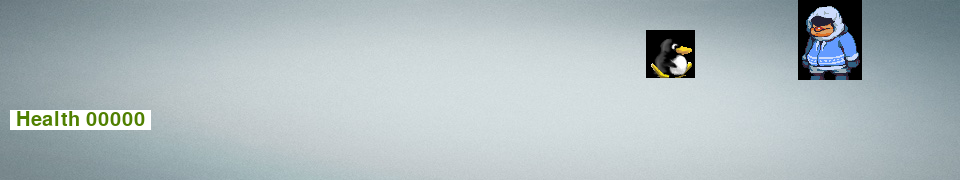

In [9]:
py_train_env.reset()
PIL.Image.fromarray(py_train_env.render(mode='rgb_array').astype(np.uint8))


In [10]:
# This ensures the PyGame Environment is actually compatible with TFEnvironment
from tf_agents.environments import utils
utils.validate_py_environment(py_train_env, episodes=3)

Run 10 steps

In [11]:
# Another test to make sure the game can run with actions passed to it
get_new_game_action = np.array(range(0,2), dtype=np.int32)

end_round_action = np.array(1, dtype=np.int32)


time_step = py_train_env.reset()
print(time_step)
cumulative_reward = time_step.reward

for _ in range(10):
  time_step = py_train_env.step(np.random.choice(get_new_game_action))
  
  cumulative_reward += time_step.reward

time_step = py_train_env.step(end_round_action)

cumulative_reward += time_step.reward
print('Final Reward = ', cumulative_reward)

TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([[[103., 118., 125.],
        [105., 120., 127.],
        [109., 124., 131.],
        ...,
        [116., 131., 136.],
        [123., 138., 143.],
        [125., 140., 145.]],

       [[103., 118., 125.],
        [105., 120., 127.],
        [106., 121., 128.],
        ...,
        [122., 137., 142.],
        [121., 136., 141.],
        [121., 136., 141.]],

       [[107., 122., 129.],
        [109., 124., 131.],
        [107., 122., 129.],
        ...,
        [125., 140., 145.],
        [118., 133., 138.],
        [122., 137., 142.]],

       ...,

       [[ 87., 110., 116.],
        [ 94., 117., 123.],
        [ 92., 115., 121.],
        ...,
        [152., 165., 171.],
        [152., 165., 171.],
        [145., 158., 164.]],

       [[ 91., 114., 120.],
        [ 92., 115., 121.],
        [ 89., 112., 118.],
        ...,
        [144., 157., 163.],
        [147., 160., 166.],
        [142., 155., 161.]],

       

#### Run 10 episodes

In [12]:


tf_eval_env = tf_py_environment.TFPyEnvironment(py_train_env)
tf_test_env = tf_py_environment.TFPyEnvironment(py_test_env)

time_step = tf_eval_env.reset()


rewards = []
steps = []
num_episodes = 10

for _ in range(num_episodes):
  episode_reward = 0
  episode_steps = 0
  while not time_step.is_last():
    # Per the section on actions, the active values are 0 (Left) and 1 (Right)
    action = tf.random.uniform([1], 0, 1, dtype=tf.int32)

    time_step = tf_eval_env.step(action)
    episode_steps += 1
    episode_reward += time_step.reward.numpy()
    
  rewards.append(episode_reward)
  steps.append(episode_steps)
  time_step = tf_eval_env.reset()

num_steps = np.sum(steps)
avg_length = np.mean(steps)
avg_reward = np.mean(rewards)

print('num_episodes:', num_episodes, 'num_steps:', num_steps)
print('avg_length', avg_length, 'avg_reward:', avg_reward)

num_episodes: 10 num_steps: 20603
avg_length 2060.3 avg_reward: 321.0


## Model Preparation

### Hypertuning Parameters

These were taken from the TF notebook and adjusted for each model due to memory constraints

In [13]:
num_iterations = 2000 # @param {type:"integer"}

initial_collect_steps = 500  # @param {type:"integer"} #10 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_max_length = 10000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-1 # @param {type:"number"} # 1e-3 
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}


In [14]:
print(isinstance(tf_eval_env, tf_environment.TFEnvironment))
print("TimeStep Specs:", tf_eval_env.time_step_spec())
print("Action Specs:", tf_eval_env.action_spec())


True
TimeStep Specs: TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': BoundedTensorSpec(shape=(960, 180, 3), dtype=tf.float32, name='observation', minimum=array([0., 0., 0.], dtype=float32), maximum=array([255., 255., 255.], dtype=float32)),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})
Action Specs: BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0, dtype=int32), maximum=array(1, dtype=int32))


### Set Up Q Network

In [15]:
fc_layer_params = (100, 50)

action_tensor_spec = tensor_spec.from_spec(py_train_env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer.
def dense_layer(num_units):
  return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal'))

# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# it's output.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))


## Set Up CNN To Feed Q Values Layer


In [16]:
layers = [tf.keras.layers.Conv2D(24, 16), tf.keras.layers.Flatten()]
layers.extend(dense_layers)
layers.append(q_values_layer)

model = sequential.Sequential(layers)

### Set Up DQN Agent

In [17]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    tf_eval_env.time_step_spec(),
    tf_eval_env.action_spec(),
    q_network = model, 
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

### Set Up Agent Policy

* The random_policy is what will be used to generate the actions that initialize the replay buffer
* The collect_policy will be used to collect actions for the replay buffer
* The eval_policy is what will be trained


In [18]:
eval_policy = agent.policy
collect_policy = agent.collect_policy
random_policy = random_tf_policy.RandomTFPolicy(tf_eval_env.time_step_spec(),
                                                tf_eval_env.action_spec())

### Model Averages Before Training

In [19]:
#@test {"skip": true}
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return
    
  print(f'Total return{total_return} / num_episodes {num_episodes}')
  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


# See also the metrics module for standard implementations of different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

Below we compute the average return with the model generating random actions.  This is our baseline

In [20]:
compute_avg_return(tf_eval_env, random_policy, num_eval_episodes)

Total return[170135.] / num_episodes 10


17013.5

### Collect Data For Replay Buffer

In [21]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=tf_eval_env.batch_size,
    max_length=replay_buffer_max_length)

In [22]:
agent.collect_data_spec

Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0, dtype=int32), maximum=array(1, dtype=int32)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': BoundedTensorSpec(shape=(960, 180, 3), dtype=tf.float32, name='observation', minimum=array([0., 0., 0.], dtype=float32), maximum=array([255., 255., 255.], dtype=float32)),
 'policy_info': (),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

In [23]:
agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

In [24]:
#@test {"skip": true}
def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)

collect_data(tf_eval_env, random_policy, replay_buffer, initial_collect_steps)

# This loop is so common in RL, that TensorFlow provides standard implementations. 
# For more details see tutorial 4 or the drivers module.
# https://github.com/tensorflow/agents/blob/master/docs/tutorials/4_drivers_tutorial.ipynb 
# https://www.tensorflow.org/agents/api_docs/python/tf_agents/drivers

### To Look At Replay Buffer

In [25]:
# For the curious:
# Uncomment to peel one of these off and inspect it.
#iter(replay_buffer.as_dataset()).next()


In [26]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)


dataset

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


<PrefetchDataset shapes: (Trajectory(
{action: (64, 2),
 discount: (64, 2),
 next_step_type: (64, 2),
 observation: (64, 2, 960, 180, 3),
 policy_info: (),
 reward: (64, 2),
 step_type: (64, 2)}), BufferInfo(ids=(64, 2), probabilities=(64,))), types: (Trajectory(
{action: tf.int32,
 discount: tf.float32,
 next_step_type: tf.int32,
 observation: tf.float32,
 policy_info: (),
 reward: tf.float32,
 step_type: tf.int32}), BufferInfo(ids=tf.int64, probabilities=tf.float32))>

In [27]:
iterator = iter(dataset)
print(iterator)

Below is long, but it shows that the model looks at the before and after of its actions

In [28]:
# For the curious:
# Uncomment to see what the dataset iterator is feeding to the agent.
# Compare this representation of replay data 
# to the collection of individual trajectories shown earlier.

iterator.next()

(Trajectory(
{'action': <tf.Tensor: shape=(64, 2), dtype=int32, numpy=
array([[0, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 0],
       [1, 0],
       [1, 1],
       [1, 1],
       [1, 0],
       [1, 1],
       [0, 1],
       [0, 1],
       [0, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 0],
       [0, 1],
       [1, 1],
       [0, 1],
       [1, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 0],
       [1, 1],
       [0, 1],
       [0, 1],
       [1, 1],
       [0, 1],
       [0, 1],
       [1, 1],
       [1, 0],
       [0, 0],
       [1, 0],
       [0, 1],
       [1, 1],
       [1, 1],
       [0, 1],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 1],

## Train The Agent Policy

Now run the buffer data collection

1. The averages are computed before training
2. During the training, averages are run and the results are appeed to the overall results, so we can see the progress made

In [29]:
# As has been stated clearly at the beginning, the code here comes primarily from the DQN Tutorial

#@test {"skip": true}
try:
  %%time
except:
  pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(tf_eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
  collect_data(tf_eval_env, agent.collect_policy, replay_buffer, collect_steps_per_iteration)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(tf_eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 7.63 µs
Total return[-94440.] / num_episodes 10
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
step = 200: loss = 0.0
step = 400: loss = 0.0
step = 600: loss = 0.0
step = 800: loss = 0.0
step = 1000: loss = 0.0
Total return[-123515.] / num_episodes 10
step = 1000: Average Return = -12351.5
step = 1200: loss = 0.0
step = 1400: loss = 0.0
step = 1600: loss = 0.0
step = 1800: loss = 0.0
step = 2000: loss = 0.0
Total return[-114225.] / num_episodes 10
step = 2000: Average Return = -11422.5


Plot The average returns against each metric gathering iteration

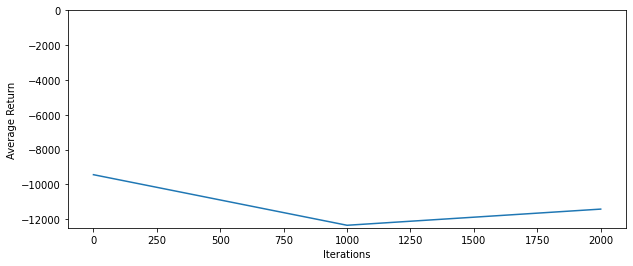

In [30]:
#@test {"skip": true}

iterations = range(0, num_iterations + 1, eval_interval)
plt.figure(figsize=(10,4))
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=0)
plt.savefig(f'{output_dir}/chart-avg-cnn-dqn.png')

### Create the video

In [31]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [32]:
def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = tf_test_env.reset() #eval_env.reset()
      video.append_data(py_test_env.render(mode="rgb_array").astype(np.uint8))
      #video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        #print(action_step.action[0].numpy())
        time_step = tf_test_env.step(action_step.action) #eval_env.step(action_step.action)
        video.append_data(py_test_env.render(mode="rgb_array").astype(np.uint8))
        #video.append_data(eval_py_env.render())
  return embed_mp4(filename)

create_policy_eval_video(eval_policy, f'{output_dir}/trained-agent-cnn-dqn', num_episodes=5)

In [33]:
compute_avg_return(tf_test_env, eval_policy, num_eval_episodes)

Total return[-114310.] / num_episodes 10


-11431.0

### Compare with a video of random actions

In [34]:
create_policy_eval_video(random_policy, f'{output_dir}/random-agent-dcnn-dqn')

In [35]:
compute_avg_return(tf_test_env, random_policy, num_eval_episodes)

Total return[-9310.] / num_episodes 10


-931.0

## References
```


@misc{TFAgents,
  title = { {TF-Agents}: A library for Reinforcement Learning in TensorFlow},
  author = {Sergio Guadarrama and Anoop Korattikara and Oscar Ramirez and
     Pablo Castro and Ethan Holly and Sam Fishman and Ke Wang and
     Ekaterina Gonina and Neal Wu and Efi Kokiopoulou and Luciano Sbaiz and
     Jamie Smith and Gábor Bartók and Jesse Berent and Chris Harris and
     Vincent Vanhoucke and Eugene Brevdo},
  howpublished = {\url{https://github.com/tensorflow/agents} },
  url = "https://github.com/tensorflow/agents",
  year = 2018,
  note = "[Online; accessed 25-June-2019]"
}
```